<a href="https://colab.research.google.com/github/kumarnikhil936/VariationalAutoencoderOnMNIST/blob/master/MNIST_on_VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import tensorflow as tf 

# Load MNIST dataset

In [25]:
from tensorflow.examples.tutorials.mnist import input_data
database = input_data.read_data_sets("./", one_hot=True)

Extracting ./train-images-idx3-ubyte.gz
Extracting ./train-labels-idx1-ubyte.gz
Extracting ./t10k-images-idx3-ubyte.gz
Extracting ./t10k-labels-idx1-ubyte.gz


# Parameters

In [0]:
lr = 0.001
epochs = 100000
batch_size = 32
image_dim = 784  # 28*28
hidden_dim = 512
code_dim = 2

# Weight and Bias Initialization

In [0]:
def xavier(input_shape):
    return tf.random_normal(shape=input_shape, stddev=1./(tf.sqrt(input_shape[0]/2.)))

In [0]:
w = {
    "input_encoder": tf.Variable(xavier([image_dim, hidden_dim])),
    "encoder_mean": tf.Variable(xavier([hidden_dim, code_dim])),
    "encoder_std": tf.Variable(xavier([hidden_dim, code_dim])),
    "latent_decoder": tf.Variable(xavier([code_dim, hidden_dim])),
    "decoder_output": tf.Variable(xavier([hidden_dim, image_dim]))
}

b = {
    "input_encoder": tf.Variable(xavier([hidden_dim])),
    "encoder_mean": tf.Variable(xavier([code_dim])),
    "encoder_std": tf.Variable(xavier([code_dim])),
    "latent_decoder": tf.Variable(xavier([hidden_dim])),
    "decoder_output": tf.Variable(xavier([image_dim]))
}

# Network Architecture

In [0]:
image_x = tf.placeholder(tf.float32, shape=[None, image_dim])

encoder_layer = tf.add(
    tf.matmul(image_x, w["input_encoder"]), b["input_encoder"])
encoder_layer = tf.nn.tanh(encoder_layer)

mean_layer = tf.add(
    tf.matmul(encoder_layer, w["encoder_mean"]), b["encoder_mean"])
std_layer = tf.add(
    tf.matmul(encoder_layer, w["encoder_std"]), b["encoder_std"])

# Reparametrization trick
epsilon = tf.random_normal(
    tf.shape(std_layer), dtype=tf.float32, mean=0., stddev=1.)
latent_layer = mean_layer + epsilon * tf.exp(0.5 * std_layer)

decoder_layer = tf.add(
    tf.matmul(latent_layer, w["latent_decoder"]), b["latent_decoder"])
decoder_layer = tf.nn.tanh(decoder_layer)

output_layer = tf.add(
    tf.matmul(decoder_layer, w["decoder_output"]), b["decoder_output"])
output_layer = tf.nn.sigmoid(output_layer)

# Loss functions 

In [0]:
# Loss = Reconstruction loss + KL Divergence prior
def loss_func(input_image, output_image):
    reconstruction_loss = input_image * tf.log(1e-10 + output_image) + (1 - input_image) * tf.log(1e-10 + 1 - output_image)
    reconstruction_loss = -tf.reduce_sum(reconstruction_loss, 1)
    
    kl_div_loss = 1 + std_layer - tf.square(mean_layer) - tf.exp(std_layer)
    kl_div_loss = -0.5 * tf.reduce_sum(kl_div_loss, 1)
    
    alpha = 1
    beta = 1
    total_loss = tf.reduce_mean(alpha * reconstruction_loss + beta * kl_div_loss)
    
    return total_loss

# Optimizer 

In [8]:
loss = loss_func(image_x, output_layer)
optimizer = tf.train.RMSPropOptimizer(lr).minimize(loss)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [0]:
init = tf.global_variables_initializer()

# Train

In [10]:
sess = tf.Session()
sess.run(init)

for i in range(epochs):
    x_batch, _ = database.train.next_batch(batch_size)
    _, loss_val = sess.run([optimizer, loss], feed_dict = {image_x: x_batch})
    if i % 5000 == 0:
        print("At epoch  {},  Loss value  is  {}".format(i, loss_val))

At epoch  0,  Loss value  is  649.304443359375
At epoch  5000,  Loss value  is  164.03941345214844
At epoch  10000,  Loss value  is  151.46078491210938
At epoch  15000,  Loss value  is  149.0137481689453
At epoch  20000,  Loss value  is  156.7965087890625
At epoch  25000,  Loss value  is  151.80206298828125
At epoch  30000,  Loss value  is  159.8260955810547
At epoch  35000,  Loss value  is  157.90457153320312
At epoch  40000,  Loss value  is  152.3543701171875
At epoch  45000,  Loss value  is  148.8138885498047
At epoch  50000,  Loss value  is  154.2884521484375
At epoch  55000,  Loss value  is  154.85882568359375
At epoch  60000,  Loss value  is  150.46717834472656
At epoch  65000,  Loss value  is  151.69308471679688
At epoch  70000,  Loss value  is  134.80056762695312
At epoch  75000,  Loss value  is  158.39862060546875
At epoch  80000,  Loss value  is  142.00006103515625
At epoch  85000,  Loss value  is  149.40716552734375
At epoch  90000,  Loss value  is  157.82215881347656
At epo

# Evaluation

In [0]:
# create some random noise 
noise_x = tf.placeholder(tf.float32, shape=[None, code_dim])

# create output from noise
decoder_layer = tf.add(
    tf.matmul(noise_x, w["latent_decoder"]), b["latent_decoder"])
decoder_layer = tf.nn.tanh(decoder_layer)

output_layer = tf.add(
    tf.matmul(decoder_layer, w["decoder_output"]), b["decoder_output"])
output_layer = tf.nn.sigmoid(output_layer)

# Visualization

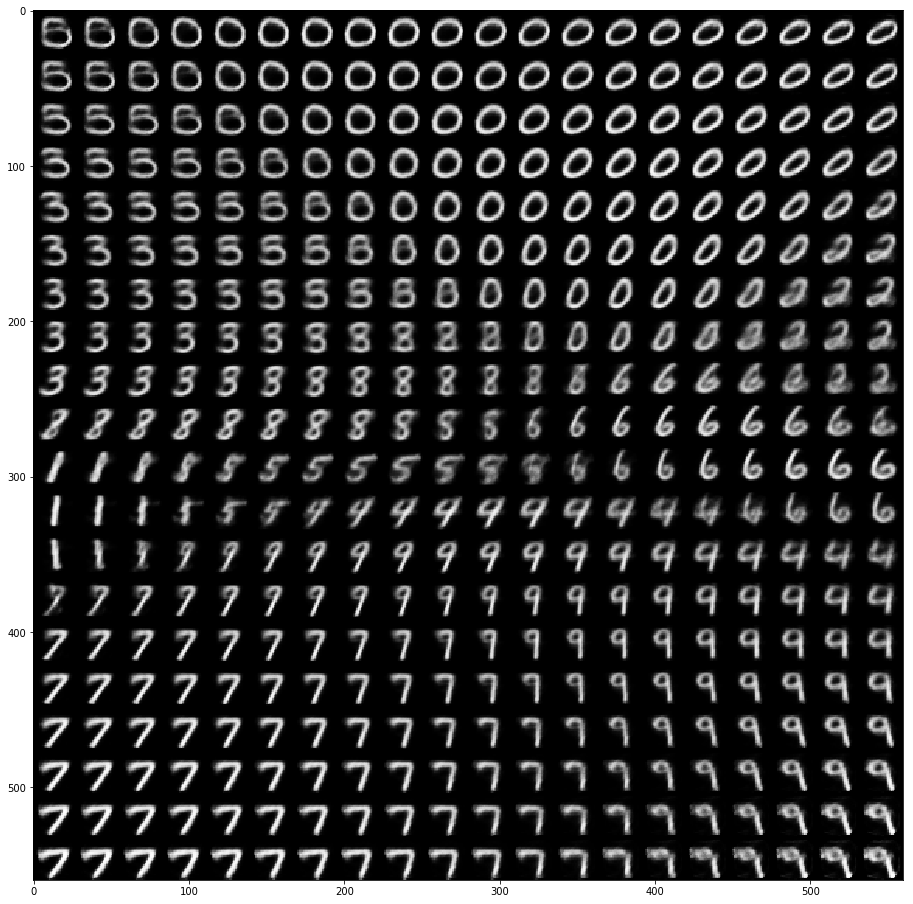

In [24]:
n = 20
x_lim = np.linspace(-5, 5, n)
y_lim = np.linspace(-2, 2, n)

empty_image = np.empty((28*n, 28*n))

for i, zi in enumerate(x_lim):
    for j, pi in enumerate(y_lim):
        generated_latent_layer = np.array([[zi, pi]] * batch_size)
        # generated_latent_layer = np.random.normal(0, 1, size=[batch_size, code_dim])
        generated_image = sess.run(output_layer, feed_dict={noise_x: generated_latent_layer})
        empty_image[(n - i -1) * 28 : (n-i) * 28, j*28 : (j+1) * 28] = generated_image[0].reshape(28, 28)
        
plt.figure(figsize=(18, 16))
x, y = np.meshgrid(x_lim, y_lim)
plt.imshow(empty_image, origin="upper", cmap="gray")
plt.grid(False)
plt.show()

(10000, 784)
(10000, 2)


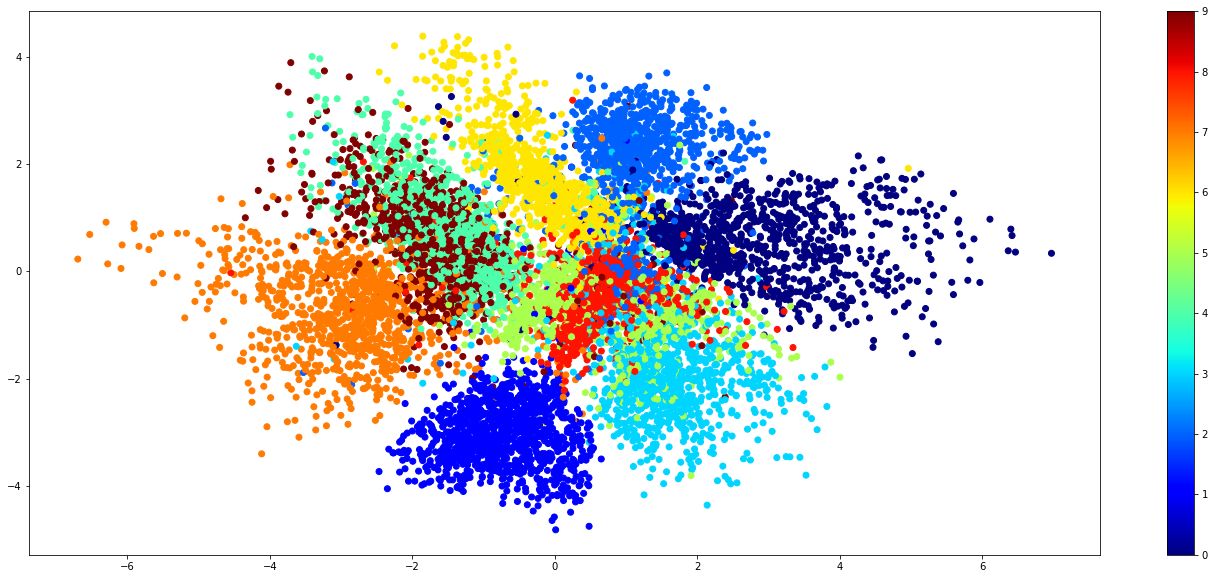

In [23]:
x_sample, y_sample = database.test.next_batch(batch_size + 15000)
print(x_sample.shape)

# Lets observe the Gaussian distribution profile of latent vectors
interim = sess.run(latent_layer, feed_dict={image_x: x_sample})
print(interim.shape)

colors = np.argmax(y_sample, 1)
plt.figure(figsize=(24, 10))
plt.scatter(interim[:, 0], interim[:, 1], c=colors, linewidth=1, cmap="jet")
plt.colorbar()
plt.grid(False)


In [0]:
# Close session
# sess.close()